In [392]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sc
import sklearn as sk
import sklearn.covariance as skc
import graph_helpers as gh

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [393]:
def remove_diag(M):
    return M - np.diag(np.diag(M))

In [394]:
def confusion_result(P0,P1):
    n,p = P0.shape
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    tol = 1e-3
    for i in range(n):
        for j in range(i):
            if abs(P0[i,j])>tol and abs(P1[i,j])>tol:  #les 2 ont une arete
                TP +=1
            elif abs(P0[i,j])<tol and abs(P1[i,j])<tol:  #les 2 n'ont pas d'arete
                TN +=1
            elif abs(P0[i,j])<tol and abs(P1[i,j])>tol:  # arete trouvée dans P1 mais pas dasn P0
                FP +=1
            else:
                FN +=1  #arete presente dans P0 mais dasn P1
    return(TP, FP, TN, FN)

In [395]:
def score(nom, P0, P1):
    TP, FP, TN, FN = confusion_result(P0,P1) 
    
    if nom == 'L1':  #norme L1
        num_vertices = P0.shape[0]
        return np.linalg.norm(P0-P1,1)/num_vertices**2
    
    elif nom == 'L0':  #norme L1
        #sc_l0 = (FP+FN)/num_vertices**2
        nb_edge = np.sum( remove_diag(P0).flatten()!=0 ) # nombre d'arretes dans P0
        return 2*(FP+FN)/nb_edge
    
    elif nom == 'F1':
        return TP/(TP+0.5*(FP+FN))

In [396]:
def gen_precision(nom_graphe,num_vertices,correlation_min=.9,rho=.5,sigma=0.5,kappa=0.6,k=3):
    """génération d'une matrice de précision"""
    A,Vx,Vy = gh.init_graph(nom_graphe,num_vertices,sigma=sigma,kappa=kappa,k=k)
    U = np.triu((1-correlation_min)*np.random.rand(num_vertices,num_vertices) + correlation_min)       
    Q = A*(U+U.T)     #matrice graphe pondéré
    L = np.diag(np.sum(Q, axis = 0)) - Q
    P0 = L + rho*np.eye(num_vertices) 
    return P0,Vx,Vy

In [397]:
def set_lambda_max(C0):
    """ dans graphical lasso, recherche lamda_max (si lamda est trop grand, graphe sans arete)"""
    lamda = 10
    u = 0
    it = 0
    while u<1e-3 and it<100:
        C1,P1 = skc.graphical_lasso(C0,lamda)
        u = np.linalg.norm(remove_diag(P1))
        it = it+1
        lamda = lamda*.8
    assert it!=50, "probleme dans la recherche de lambda_max"
    return lamda/.8

In [398]:
def repport_performance(P0,num_samples,nrep=10,nlambda=30,lmax=-1,type_score='F1'):
    num_vertices = P0.shape[0]
    C0 = np.linalg.inv(P0)
    X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
    C = X.T@X/num_samples   
    if lmax<0:
        lmax = set_lambda_max(C)
    lmin = lmax/1000
    list_score = []
    lambda_list = list(np.linspace(lmin,lmax,nlambda))
    for i in range(nrep):
        X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
        C = X.T@X/num_samples
        score_l = []
        for lamda in lambda_list:
            C1,P1 = skc.graphical_lasso(C,lamda)
            score_l.append(score(type_score, P0, P1))                 
        list_score.append(score_l)
    M = np.mean(list_score, axis=0)  
    S = np.std(list_score, axis=0) 
    return lambda_list, M, S

In [399]:
 def plot_lambda_influ(nom_graphe,correlation_min,num_vertices,sigma,num_samples,nlambda=30,type_score='F1',lmin=-1,lmax=-1,nrep=30,nom_figure=''):
        """trace score en fonction de lambda"""
        P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,sigma)
        lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda,lmax,type_score)
        plt.plot(lambda_list,M)
        plt.fill_between(lambda_list,M-S, M+S ,alpha=0.3)        
        plt.title("Graphe {0}, correlation_min = {1}, m = {2}, sigma = {3}, n = {4}".format(nom_graphe,correlation_min,num_vertices,sigma,num_samples))
        plt.xlabel("lambda")
        plt.ylabel("score {0}".format(type_score))
        if nom_figure!='':
            plt.savefig(nom_figure) 

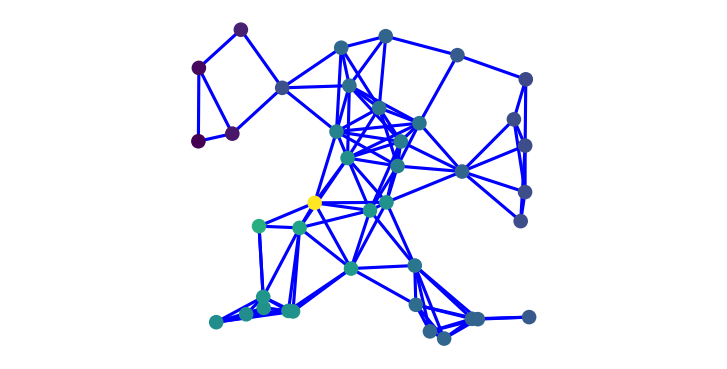

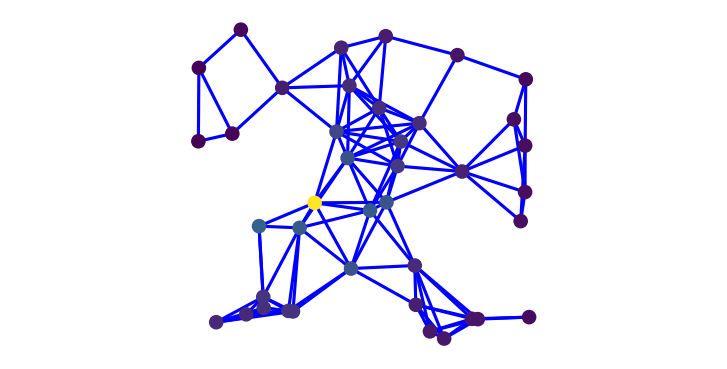

In [427]:
import os
rep = './figures/covariances/'
os.makedirs(rep, exist_ok=True)

correlation_min = 1   #graphe non pondéré

rho_list = [1e-10,1]

nom_graphe = "kvoisins"
num_vertices = 40
k0 = num_vertices//2 # vertex central

nom_graphe = "grilleCarree"
num_vertices = 11*11
k0 = num_vertices//2 # vertex central

nom_graphe = "ligne"
num_vertices = 25
k0 = num_vertices//2 # vertex central

nom_graphe = "rbf_random"
num_vertices = 40
k0 = num_vertices//2 


k = 0
for rho in rho_list:

    P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
    C0 = np.linalg.inv(P0)

    fig = plt.figure(figsize=(6, 3), dpi=150) 
    gh.dessin_graphe(P0,Vx,Vy,C0[k0,:])
    fig.savefig('{0}{1}_rho={2}_cov.png'.format(rep,nom_graphe,k), dpi=200)
    k = k+1

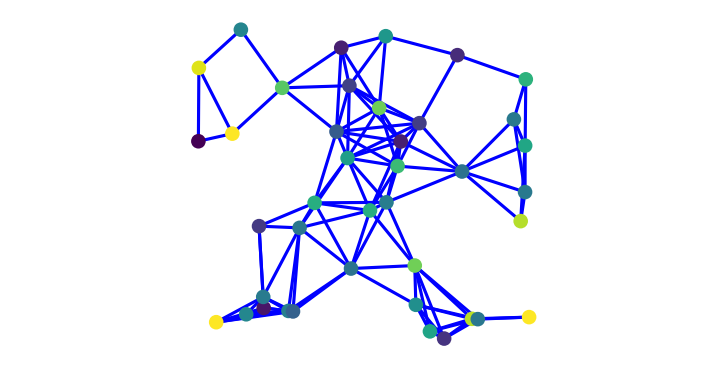

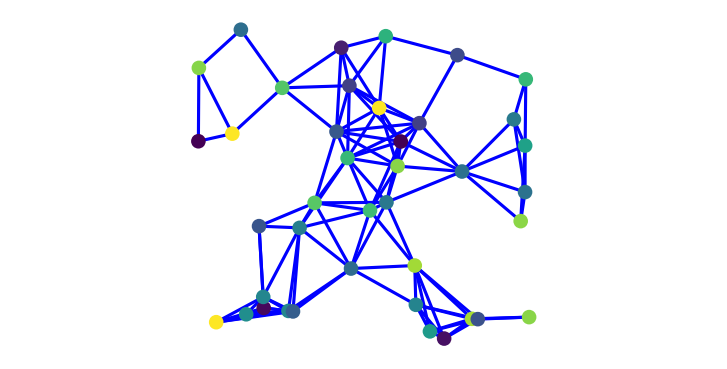

In [401]:
import os
rep = './figures/signaux/'
os.makedirs(rep, exist_ok=True)

correlation_min = 1   #graphe non pondéré

rho_list = [1e-10,10000]

nom_graphe = "grilleCarree"
num_vertices = 17*17

nom_graphe = "kvoisins"
num_vertices = 40


nom_graphe = "ligne"
num_vertices = 40

nom_graphe = "rbf_random"
num_vertices = 40

k = 0
for rho in rho_list:
    P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
    C0 = np.linalg.inv(P0)
    x = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,1)).T
    x = x-np.mean(x)
    x = x/np.std(x)
    x = np.clip(x,-1.5,1.5)
    fig = plt.figure(figsize=(6, 3), dpi=150) 
    gh.dessin_graphe(P0,Vx,Vy,x)
    fig.savefig('{0}{1}_rho={2}.png'.format(rep,nom_graphe,k), dpi=200)
    k = k+1


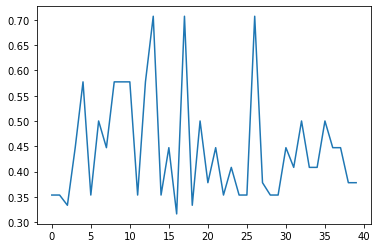

In [419]:
nom_graphe = "kvoisins"
num_vertices = 40

nom_graphe = "rbf_random"
num_vertices = 40

rho = 1e-5
P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
P1 = np.diag( np.diag(P0)**(-1/2) ) @ P0 @ np.diag( np.diag(P0)**(-1/2) )
C0 = np.linalg.inv(P1)
plt.plot( np.diag(P0)**(-1/2) )

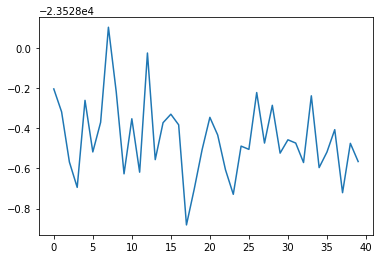

In [403]:
rho = 1e-10
P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho)
C0 = np.linalg.inv(P0)
#plt.imshow(C0)
x = np.real( (sc.linalg.sqrtm(C0) )@np.random.randn(num_vertices,1)).T  
plt.plot(x.flatten())

# influence de rho et lamda : 

In [ ]:
nom_graphe = "rbf_random"
num_vertices = 40

i = 0
for rho in [1e-1, 0.5,0.8,1,2,3]:
#for rho in [1e-5,0.8,1,2,3]:
    P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = 1000, kappa = .25, k=4)
    np.random.seed(i)
    i+=1
    lambda_list, M, S = repport_performance(P0,num_samples)
    plt.plot(lambda_list,M, label = r"$\rho$ = {0}".format(rho))
    plt.fill_between(lambda_list, M-S, M+S ,alpha=0.3)
plt.legend(loc=0)
plt.xlabel("$\lambda$")
plt.ylabel("F$_1$")
#plt.axis([0, 1.3, 0, 1.1])
plt.show()
fig.tight_layout()
fig.savefig('rbf_n16_m400_lambda.png', dpi=200) 

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00043878729273894024, tolerance: 0.0002570833505379229
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021058456969771377, tolerance: 0.0002198741938696089
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008114764033892108, tolerance: 0.000258970983780628
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -7.904e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014342845386723369, tolerance: 0.00020746532083584996
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011468917240022858, tolerance: 0.00019317546629067336
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWa

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 5.035e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -9.704e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010758300531135134, tolerance: 0.00021866652529404235
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 4.283e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 7.546e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 4.489e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012638854400164323, tolerance: 0.000206237422

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 9.823e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000707358484694387, tolerance: 0.0002322090022166737
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011447551623737784, tolerance: 0.0002346638027087252
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarnin

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 7.121e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 8.158e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008838395620167638, tolerance: 0.00019198695543327956
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 5.980e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034019143186423406, tolerance: 0.0002618648076532941
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007858609702389607, tolerance: 0.0002525309949784592
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarnin

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.155e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.061e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008357661300602004, tolerance: 0.0002122283826916479
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number o

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003302046361467248, tolerance: 0.0002549540992703994
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010710336771589724, tolerance: 0.0002544828307434394
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017289830505546444, tolerance: 0.0002700835344447865
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -3.395e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034896313685894853, tolerance: 0.0002683574742250896
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00354487342058607, tolerance: 0.00024188266406678275
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarn

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 7.309e-04
  warnings.warn('graphical_lasso: did not converge after '


In [405]:
nom_graphe = "rbf_random"
num_vertices = 16
correlation_min = 1   #graphe non pondéré
num_samples = 100
rho = 0.8

plot_lambda_influ(nom_graphe,correlation_min,num_vertices,rho,num_samples,type_score='F1',nrep=5)

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7181622679777249, tolerance: 0.007385515213489598
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.28510298843117, tolerance: 0.007234486385231529
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 0.007219982155140511
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/cov

FloatingPointError: The system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

# et en changeant n  : 
sigma ne change pas trop (autour de 0.5)
dégradation des résultats quand il y a moins d'échantillons

# et en changeant m
sigma ne change pas trop (autour de 0.5)

# influence de n

In [414]:
nom_graphe = "rbf_random"
correlation_min = 1   #graphe non pondéré

N_list =  [100]
nlambda = 20
nrep = 5
rho = 0.8

 
num_vertices = 49
P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = .5, kappa = .6);
num_samples = 600
lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda);
np.max(M)

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.957509927021618e-06, tolerance: 2.2617712722654217e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.775915054965144e-06, tolerance: 2.6653667619579654e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.74979151456203e-06, tolerance: 2.754601448901517e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.741e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.381e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.531e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.686492149683777e-06, tolerance: 3.14359734186

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 3.556e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0136483284886068e-05, tolerance: 2.856394087314899e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4562808359341785e-05, tolerance: 2.67793887720369e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarn

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.521670796487549e-06, tolerance: 2.951391957529474e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.832185570638939e-05, tolerance: 3.5638159899853792e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7986871515295478e-05, tolerance: 3.0901220355404615e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/pyth

0.7720821377395808

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.698e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -3.053e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.812e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.536e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/a

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.497e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.304e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.013e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -6.346e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/an

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 7.532e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.095e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.939e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -9.214e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 4.709e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.717e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 7.893e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.858e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/ana

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.743e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.168e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -4.166e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.286e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.6654086691500525e-06, tolerance: 4.512665782126974e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.146304694123374e-06, tolerance: 3.38240200593416e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5873972953696515e-06, tolerance: 4.473738928777757e-06
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/envs/py3k8/lib/python

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.900e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.352e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.211e-02
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -7.311e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/an

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 5.292e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 3.524e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.634e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -5.651e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/an

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -4.166e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.202e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 3.001e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.278e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/a

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 3.823e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.393e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.335e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:229: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.757182670311541e-06, tolerance: 2.6151426944

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.460e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.568e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.643e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.931e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/a

/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -3.688e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.482e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.942e-03
  warnings.warn('graphical_lasso: did not converge after '
/opt/anaconda3/envs/py3k8/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.093e-04
  warnings.warn('graphical_lasso: did not converge after '
/opt

KeyboardInterrupt: 

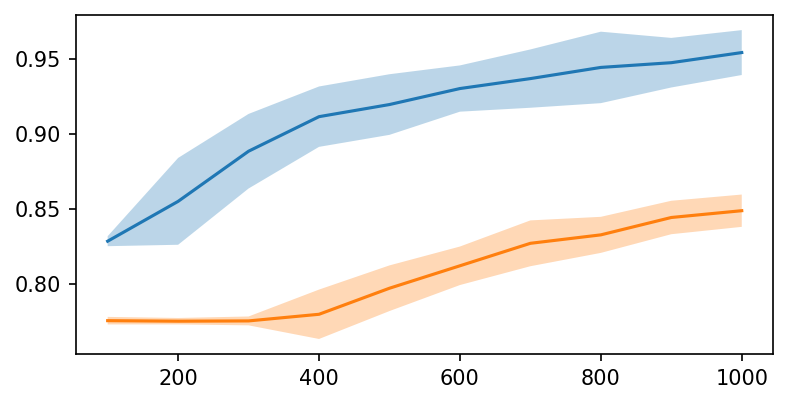

In [418]:
nom_graphe = "rbf_random"
correlation_min = 1   #graphe non pondéré


nbr_N = 10
N_list =  np.linspace(100,1000,nbr_N).astype(int)
nlambda = 20
nrep = 20
rho = 1

fig = plt.figure(figsize=(6, 3), dpi=150)
for m in [16,36,49] : 
    num_vertices = m
    P0,Vx,Vy = gen_precision(nom_graphe,num_vertices,correlation_min,rho, sigma = .5, kappa = .6)
    score_list = np.zeros(nbr_N)
    std_list = np.zeros(nbr_N)
    for j in range(len(N_list)):
        num_samples = N_list[j]
        lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda)
        score_list[j] = np.max(M)
        std_list[j] = S[ np.argmax(M) ]
    plt.plot(N_list,score_list, label = "$n$ = {0}".format(m))
    plt.fill_between(N_list,score_list-std_list, score_list+std_list,alpha=0.3)
plt.legend(loc=0)
plt.xlabel("nombre d'échantillons $m$")
plt.ylabel("F$_1$")
#plt.axis([100, 600, 0.85, 1])
plt.show()
fig.tight_layout()
fig.savefig('rbf_m_n_2.png', dpi=200) 

In [382]:
plt.show()